### 생존분석에 사용되는 scikit-survival
> An Introduction to Survival Analysis with scikit-survival 페이지의 소스코드를 이용함<br>
> (https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb)

* scikit-survival이 설치되지 않았다면, 설치 후 이용<br>
`!conda install -c sebp scikit-survival`

In [1]:
#폐암환자 데이터 불러오기
from sksurv.datasets import load_veterans_lung_cancer

In [2]:
data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [3]:
import pandas as pd
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


---

Text(0.5, 0, 'time $t$')

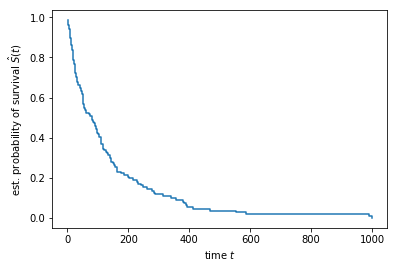

In [7]:
#Kaplan-Meier estimator 이용해보기

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

#$로 묶으면 이텔릭체, \hat{}로 묶으면 햇 기호

In [8]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [9]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

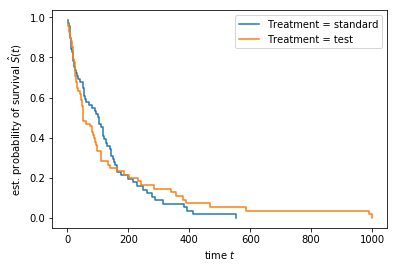

In [10]:
#survival과 test 분류군별 생존곡선 그리기

#standard끼리 한 번, test끼리 한 번 K-M plot을 그린다. 분류는 masking을 통해서.
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(data_y["Status"][mask_treat], data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post", label="Treatment = %s" % treatment_type)
    
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

---
### 다변량 생존 모델
* Cox's proportional hazard's model 이용할 것

In [12]:
from sksurv.preprocessing import OneHotEncoder

#data_x를 숫자 값으로 변형해 이용. 각 data마다 0 or 1의 값으로 표시되게끔 재설정됨
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [13]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [14]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

In [16]:
#분류군별로 환자를 분류하기 위한 마스크 만들기
#모든 group은 65세, Karnofsky_score=60, 1개월이며
#Celltype=squamous 중 치료 O/X group
#Celltype=smallcell 중 치료 O/X group 으로 구분한다.

x_new = pd.DataFrame.from_dict({
    1: [65,0,0,1,60,1,0,1],
    2: [65,0,0,1,60,1,0,0],
    3: [65,0,1,0,60,1,0,0],
    4: [65,0,1,0,60,1,0,1]},
    columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


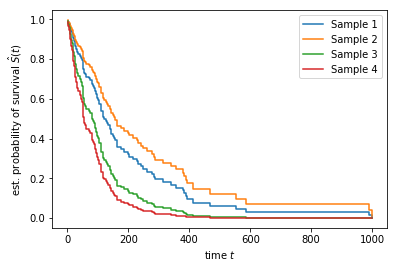

In [19]:
#네 그룹의 생존확률 시각화
pred_surv = estimator.predict_survival_function(x_new) #마스크 적용
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where='post', label='Sample %d' % (i+1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")